In [1]:
import sweetviz as sv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sweetviz\graph.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [40]:
df = pd.read_csv('da_internship_task_dataset.csv')
df = pd.DataFrame(df)

**Basic info**

In [34]:
print(df.info(), "\n")
print(df.describe(), "\n")
print(df.isnull().sum(), "\n")
print(df["uuid"].nunique(), "\n")  #unique values in uuid column
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   uuid                122746 non-null  object  
 1   day_id              122746 non-null  object  
 2   license             122746 non-null  object  
 3   model               122746 non-null  object  
 4   feature             122746 non-null  object  
 5   requests_cnt        122746 non-null  float64 
 6   spent_amount        122746 non-null  float64 
 7   spent_amount_group  122746 non-null  category
dtypes: category(1), float64(2), object(5)
memory usage: 6.7+ MB
None 

        requests_cnt   spent_amount
count  122746.000000  122746.000000
mean       51.260742      12.227798
std       167.977380      37.588494
min         1.000000       0.270000
25%        18.000000       5.140000
50%        32.000000       8.020000
75%        54.000000      13.060000
max     12900.000000

In [18]:
#sweetviz report
#report = sv.analyze(df)
#report.show_html('Sweetviz_Report_Pairwise.html')

**Spent amount per model**

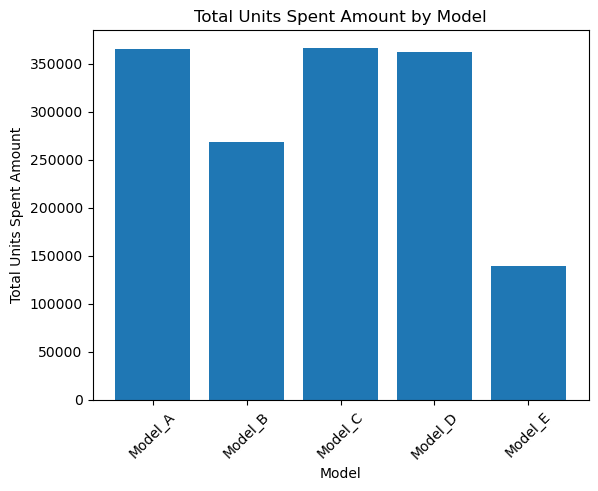

In [ ]:
agg_df = df.groupby('model')['spent_amount'].sum().reset_index()
plt.bar(agg_df['model'], agg_df['spent_amount'])
plt.xlabel('Model')
plt.ylabel('Total Units Spent Amount')
plt.title('Total Units Spent Amount by Model')
plt.xticks(rotation=45)
plt.show()

**relationship between spent_amount and requests_cnt**

Correlation between requests_cnt and spent_amount: 0.9441770579957468


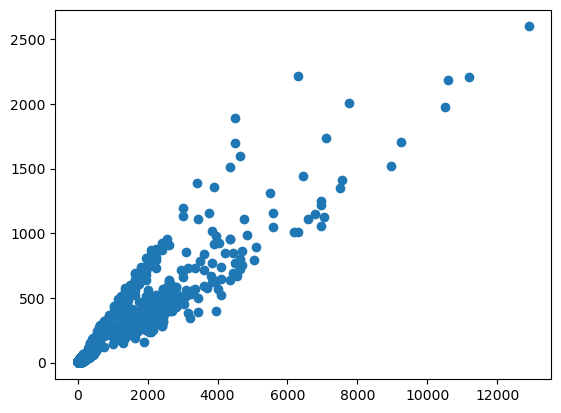

In [35]:
plt.scatter(df['requests_cnt'], df['spent_amount'])

#correlation 
correlation = np.corrcoef(df['requests_cnt'], df['spent_amount'])[0, 1]
print(f'Correlation between requests_cnt and spent_amount: {correlation}')

**user-based spent_amount and requests_cnt analysis**

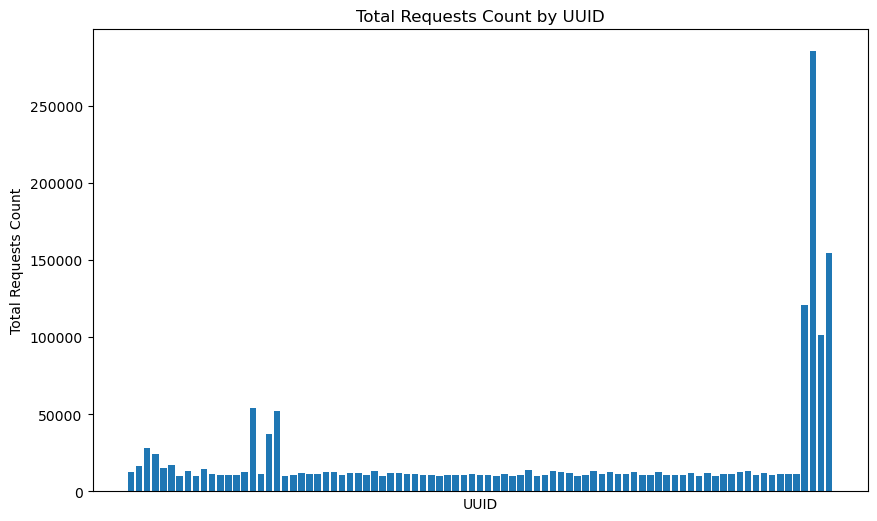

In [ ]:
agg_df2 = df.groupby('uuid')['requests_cnt'].sum().reset_index()
agg_df2 = agg_df2[agg_df2['requests_cnt'] > 10000]  #example threshold
plt.figure(figsize=(10,6))
plt.bar(agg_df2['uuid'], agg_df2['requests_cnt'])
plt.xlabel('UUID')
plt.ylabel('Total Requests Count')
plt.title('Total Requests Count by UUID')
plt.xticks(ticks =[])
plt.show()

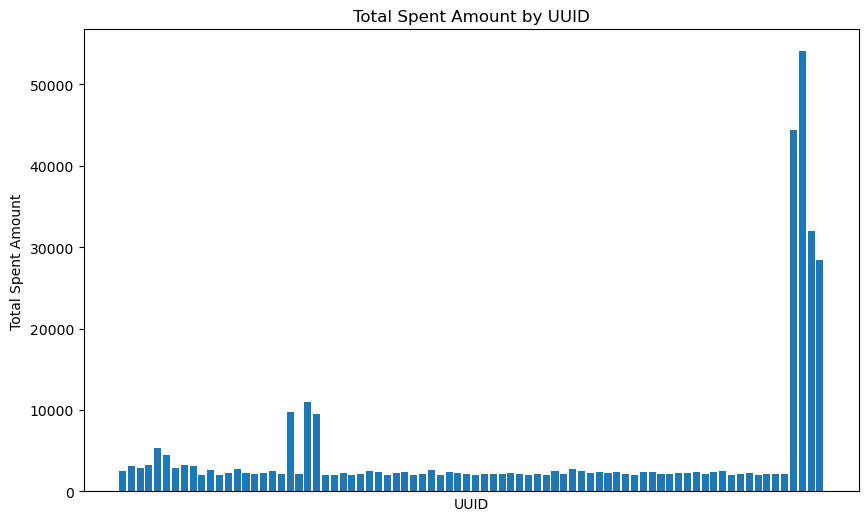

In [ ]:
agg_df2 = df.groupby('uuid')['spent_amount'].sum().reset_index()
agg_df2 = agg_df2[agg_df2['spent_amount'] > 2000]  #example threshold, around 3000 is a good cut-off
plt.figure(figsize=(10,6))
plt.bar(agg_df2['uuid'], agg_df2['spent_amount'])
plt.xlabel('UUID')
plt.ylabel('Total Spent Amount')
plt.title('Total Spent Amount by UUID')
plt.xticks(ticks =[])
plt.show()

In [ ]:
#outlier analysis - UUID with highest requests_cnt
max_requests_uuid = agg_df2.loc[agg_df2['requests_cnt'].idxmax()]
print(f'UUID with the highest number of requests: {max_requests_uuid["uuid"]} with {max_requests_uuid["requests_cnt"]} requests')

UUID with the highest number of requests: user_935 with 285050.0 requests


In [38]:
#quantiles for spent_amount per uuid
agg_spent = df.groupby('uuid')['spent_amount'].sum().reset_index()
quantiles_spent = agg_spent['spent_amount'].quantile([0.5, 0.75, 0.9]).round()

print("Quantiles for total spent_amount per uuid:")
print(quantiles_spent)

#quantiles for requests_cnt per uuid
agg_requests = df.groupby('uuid')['requests_cnt'].sum().reset_index()
quantiles_requests = agg_requests['requests_cnt'].quantile([0.5, 0.75, 0.9]).round()

print("Quantiles for total requests_cnt per uuid:")
print(quantiles_requests)

Quantiles for total spent_amount per uuid:
0.50     521.0
0.75    1120.0
0.90    1674.0
Name: spent_amount, dtype: float64
Quantiles for total requests_cnt per uuid:
0.50    1986.0
0.75    4140.0
0.90    7890.0
Name: requests_cnt, dtype: float64


In [43]:
#user segmentation based on requests_cnt
agg_df2 = df.groupby('uuid')['requests_cnt'].sum().reset_index()

requests_cnt_bins = [0, 10000, 20000, np.inf] #thresholds based on a previous graph
labels = ['Low', 'Medium', 'High']

user_groups = pd.cut(agg_df2['requests_cnt'], bins=requests_cnt_bins, labels=labels, include_lowest=True)

group_counts = user_groups.value_counts().sort_index()

print("User segmentation based on requests_cnt:")
print(group_counts)

User segmentation based on requests_cnt:
requests_cnt
Low       1779
Medium      78
High         9
Name: count, dtype: int64


In [52]:
#user segmentation based on spent_amount
user_total_spent = df.groupby('uuid')['spent_amount'].sum().reset_index()

spent_amount_bins = [0, 1000, 3000, np.inf]
labels = ['Low', 'Medium', 'High']

user_groups = pd.cut(user_total_spent['spent_amount'], bins=spent_amount_bins, labels=labels, include_lowest=True)

group_counts = user_groups.value_counts().sort_index()

print("User segmentation based on spent_amount:")
print(group_counts)

User segmentation based on spent_amount:
spent_amount
Low       1339
Medium     514
High        13
Name: count, dtype: int64


In [55]:
#model usage distribution across user segments (based on requests_cnt)
user_total_requests = df.groupby('uuid')['requests_cnt'].sum()

labels = ['Low_Activity_User', 'Medium_Activity_User', 'High_Activity_User']

user_segments = pd.cut(user_total_requests, 
                    bins=requests_cnt_bins, 
                    labels=labels, 
                    include_lowest=True)

user_segments.name = 'user_segment'

df['user_segment'] = df['uuid'].map(user_segments)

model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()

model_segment_df.rename(columns={'uuid': 'unique_user_count'}, inplace=True)

print("Model usage distribution across user segments (based on requests_cnt):")
print(model_segment_df)

Model usage distribution across user segments (based on requests_cnt):
            user_segment    model  unique_user_count
0      Low_Activity_User  Model_A                289
1      Low_Activity_User  Model_B                194
2      Low_Activity_User  Model_C                134
3      Low_Activity_User  Model_D                174
4      Low_Activity_User  Model_E                 92
5   Medium_Activity_User  Model_A                292
6   Medium_Activity_User  Model_B                213
7   Medium_Activity_User  Model_C                180
8   Medium_Activity_User  Model_D                207
9   Medium_Activity_User  Model_E                141
10    High_Activity_User  Model_A                262
11    High_Activity_User  Model_B                203
12    High_Activity_User  Model_C                330
13    High_Activity_User  Model_D                324
14    High_Activity_User  Model_E                208


C:\Users\Pc\AppData\Local\Temp\ipykernel_4220\3339114028.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()


In [57]:
#model usage distribution across user segments (based on spent_amount)
user_total_spent = df.groupby('uuid')['spent_amount'].sum()

labels = ['Low_Activity_User', 'Medium_Activity_User', 'High_Activity_User']

user_segments = pd.cut(user_total_spent, 
                    bins=spent_amount_bins, 
                    labels=labels, 
                    include_lowest=True)

user_segments.name = 'user_segment'

df['user_segment'] = df['uuid'].map(user_segments)

model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()

model_segment_df.rename(columns={'uuid': 'unique_user_count'}, inplace=True)

print("Model usage distribution across user segments (based on spent_amount):")
print(model_segment_df)

Model usage distribution across user segments (based on spent_amount):
            user_segment    model  unique_user_count
0      Low_Activity_User  Model_A                609
1      Low_Activity_User  Model_B                435
2      Low_Activity_User  Model_C                423
3      Low_Activity_User  Model_D                492
4      Low_Activity_User  Model_E                294
5   Medium_Activity_User  Model_A                227
6   Medium_Activity_User  Model_B                172
7   Medium_Activity_User  Model_C                214
8   Medium_Activity_User  Model_D                209
9   Medium_Activity_User  Model_E                146
10    High_Activity_User  Model_A                  7
11    High_Activity_User  Model_B                  3
12    High_Activity_User  Model_C                  7
13    High_Activity_User  Model_D                  4
14    High_Activity_User  Model_E                  1


C:\Users\Pc\AppData\Local\Temp\ipykernel_4220\1549859170.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()


**Model-based analysis**

In [11]:
#porównanie ilości użyć danego modelu w zależności od używanej licencji (kolumna license)
#z posdziałem na bloki w zależności od license (posortowane malejąco według requests_cnt)

license_usage = df.groupby(['model', 'license'])['requests_cnt'].sum().reset_index()
license_usage = license_usage.sort_values(by='requests_cnt', ascending=False)
for i in range(len(df['license'].unique())):
    license_block = license_usage[license_usage['license'] == df['license'].unique()[i]]
    print(license_block)

      model  license  requests_cnt
10  Model_C  Premium      676182.0
14  Model_D  Premium      406016.0
2   Model_A  Premium      258014.0
18  Model_E  Premium      206760.0
6   Model_B  Premium      172656.0
      model license  requests_cnt
8   Model_C   Basic      366564.0
12  Model_D   Basic      333519.0
0   Model_A   Basic      181463.0
4   Model_B   Basic      104788.0
16  Model_E   Basic       91789.0
      model     license  requests_cnt
13  Model_D  Enterprise      548537.0
9   Model_C  Enterprise      498204.0
1   Model_A  Enterprise      309526.0
5   Model_B  Enterprise      294919.0
17  Model_E  Enterprise      274188.0
      model   license  requests_cnt
15  Model_D  Standard      606078.0
11  Model_C  Standard      400846.0
3   Model_A  Standard      242930.0
19  Model_E  Standard      161064.0
7   Model_B  Standard      158008.0


In [ ]:
#średnia spent_amount per model
model_usage = df.groupby('model')['spent_amount'].mean().reset_index()
print(model_usage)

     model  spent_amount
0  Model_A      9.596685
1  Model_B     11.603898
2  Model_C     15.005187
3  Model_D     14.806012
4  Model_E     10.946868


In [10]:
#porównanie ilości użyć danego modelu dla różnych wartości z kolumny feature (posortowane malejąco według requests_cnt)
feature_usage = df.groupby(['model', 'feature'])['requests_cnt'].sum().reset_index()
feature_usage = feature_usage.sort_values(by='requests_cnt', ascending=False)
print(feature_usage)

      model    feature  requests_cnt
10  Model_C  Feature_1      937253.0
15  Model_D  Feature_1      798043.0
16  Model_D  Feature_2      603601.0
11  Model_C  Feature_2      404161.0
0   Model_A  Feature_1      363290.0
12  Model_C  Feature_3      358344.0
20  Model_E  Feature_1      329741.0
1   Model_A  Feature_2      295124.0
6   Model_B  Feature_2      252778.0
17  Model_D  Feature_3      251417.0
5   Model_B  Feature_1      241452.0
2   Model_A  Feature_3      231346.0
21  Model_E  Feature_2      200811.0
7   Model_B  Feature_3      184196.0
13  Model_C  Feature_4      162050.0
18  Model_D  Feature_4      124580.0
19  Model_D  Feature_5      116509.0
22  Model_E  Feature_3      110376.0
14  Model_C  Feature_5       79988.0
3   Model_A  Feature_4       69566.0
23  Model_E  Feature_4       52162.0
24  Model_E  Feature_5       40711.0
9   Model_B  Feature_5       35448.0
4   Model_A  Feature_5       32607.0
8   Model_B  Feature_4       16497.0
